### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

In [2]:
def auc_pr(y_test, y_pred):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    
    return auc(recall, precision)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [133]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [134]:
#your code here

auc_pr_array = []
auc_roc_array =[]

for i in np.logspace(-3., 1, num=10):
    
    svc = LinearSVC(max_iter=100000, C=i).fit(X_train, y_train)
    
    auc_pr_array.append(cross_val_score(svc, X_test, y_test, cv=3, scoring=auc_pr).mean())
    
    auc_roc_array.append(cross_val_score(svc, X_test, y_test, cv=3, scoring="roc_auc").mean())
    
    print(i)

KeyboardInterrupt: 

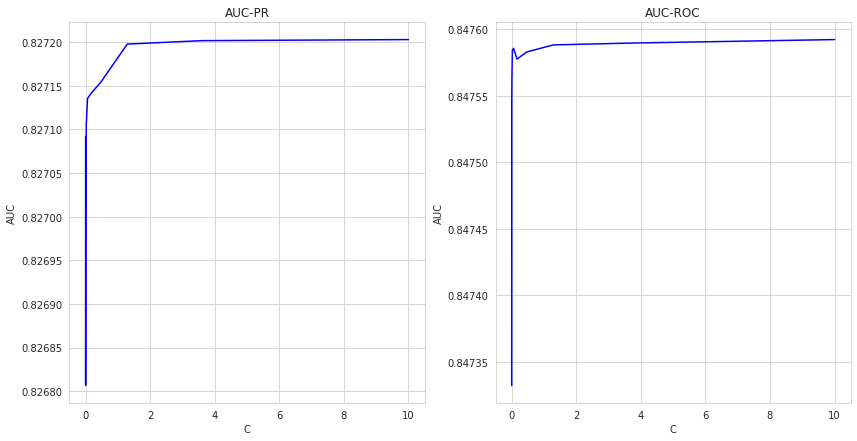

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].plot(np.logspace(-3., 1, num=10), auc_pr_array, label='AUC-PR', color='blue')
axs[1].plot(np.logspace(-3., 1, num=10), auc_roc_array, label='AUC-ROC', color='blue')

axs[0].set_title('AUC-PR')
axs[1].set_title('AUC-ROC')

for ax in axs:
    ax.set_xlabel('C')
    ax.set_ylabel('AUC')

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [45]:
#your code here
svc = LinearSVC(max_iter=100000, C=4).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, svc_pred)
fpr, tpr, thresholds = roc_curve(y_test, svc_pred)
print('SVC PR-AUC:', auc(recall, precision))
print('SVC ROC-AUC:', auc(fpr, tpr))

SVC PR-AUC: 0.8296889170647636
SVC ROC-AUC: 0.8476457642781672


Text(0, 0.5, 'tpr')

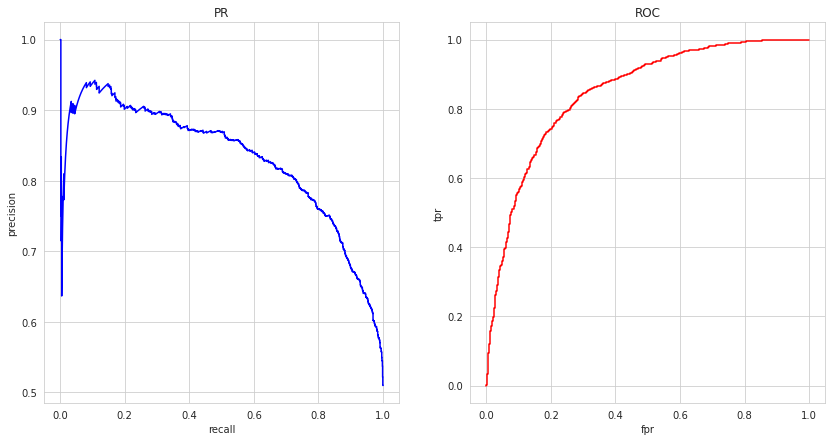

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].plot(recall, precision, label='PR', color='blue')
axs[1].plot(fpr, tpr, label='ROC', color='red')

axs[0].set_title('PR')
axs[1].set_title('ROC')

axs[0].set_xlabel('recall')
axs[0].set_ylabel('precision')

axs[1].set_xlabel('fpr')
axs[1].set_ylabel('tpr')

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [53]:
auc_pr_array = []
auc_roc_array =[]

for i in np.logspace(-3., 1, num=10):
    
    lr = LogisticRegression(max_iter=100000, C=i).fit(X_train, y_train)
    
    auc_pr_array.append(cross_val_score(lr, X_test, y_test, cv=3, scoring=auc_pr).mean())
    
    auc_roc_array.append(cross_val_score(lr, X_test, y_test, cv=3, scoring="roc_auc").mean())
    
    print(i)

0.001
0.0027825594022071257
0.007742636826811269
0.021544346900318832
0.05994842503189409
0.1668100537200059
0.46415888336127775
1.2915496650148828
3.593813663804626
10.0


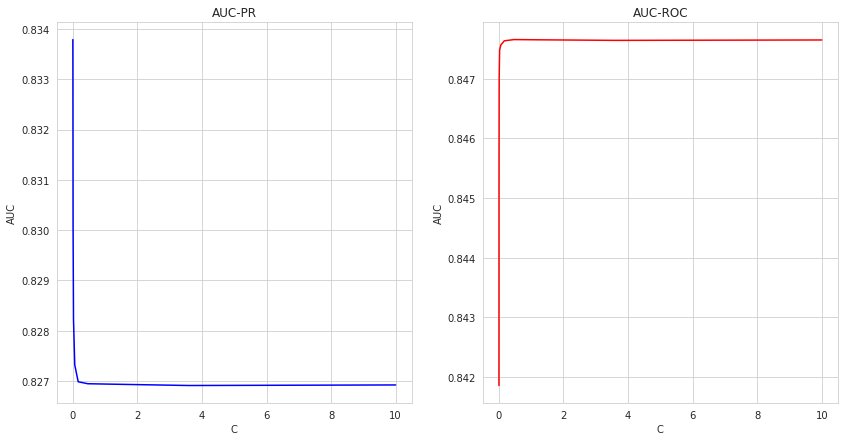

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].plot(np.logspace(-3., 1, num=10), auc_pr_array, label='AUC-PR', color='blue')
axs[1].plot(np.logspace(-3., 1, num=10), auc_roc_array, label='AUC-ROC', color='red')

axs[0].set_title('AUC-PR')
axs[1].set_title('AUC-ROC')

for ax in axs:
    ax.set_xlabel('C')
    ax.set_ylabel('AUC')

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [5]:
#your code here
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2,
                           random_state=32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=32)

In [35]:
svc = SVC(kernel='linear', random_state=32).fit(X_train, y_train)
w = svc.coef_[0]         
b = svc.intercept_[0]      
x_points = np.linspace(-4, 4) 
y_points = -(w[0] / w[1]) * x_points - b / w[1]

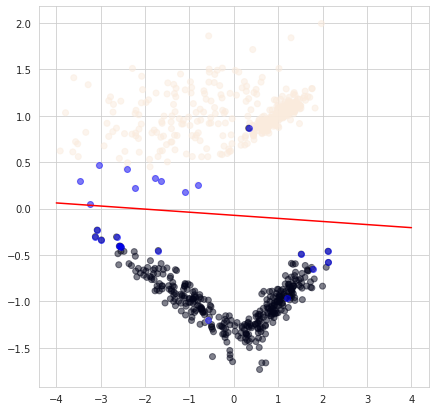

In [37]:
plt.figure(figsize=(7, 7))

plt.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.5)
plt.scatter(svc.support_vectors_[:,0], svc.support_vectors_[:,1], color='blue', alpha=0.5)
plt.plot(x_points, y_points, c='r')

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [82]:
#your code here
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=32)

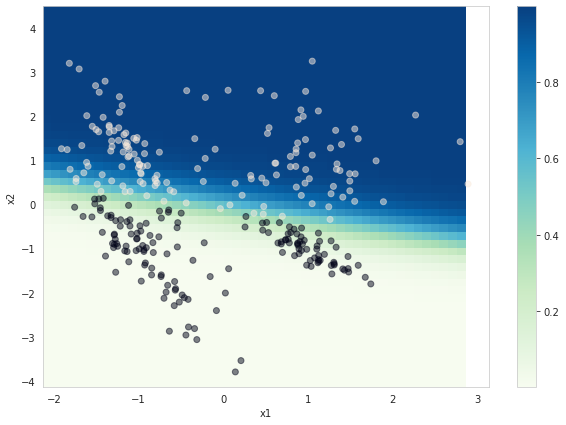

In [83]:
#your code here
lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)

gridx1, gridx2 = np.meshgrid(np.linspace(X_train[:,0].min(), X_train[:,0].max(),50), np.linspace(X_train[:,1].min(), X_train[:,1].max(),50))

grid = np.c_[gridx1.flatten(), gridx2.flatten()]

prob = lr.predict_proba(grid)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 7))
plt.pcolor(gridx1,gridx2,prob[:,1].reshape(50,50), cmap=plt.cm.GnBu)
plt.colorbar()
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2');

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [2]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [6]:
#your code here

In [3]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [4]:
svc = LinearSVC(max_iter=100000, C=4).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))

SVC ROC-AUC: 0.8476457642781672


In [5]:
lr = LogisticRegression(max_iter=100000, C=4).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, lr_pred))

Logistic regression ROC-AUC: 0.847874682570339


In [6]:
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
lr_pred = lr.predict_proba(X_test)[:, 1]

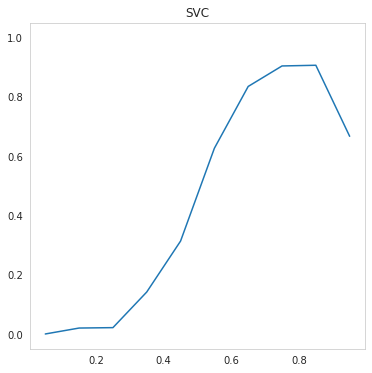

In [7]:
plot_calibration_curve(y_test, svc_pred)
plt.title('SVC');

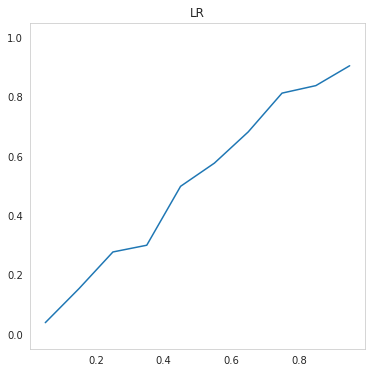

In [8]:
plot_calibration_curve(y_test, lr_pred)
plt.title('LR');

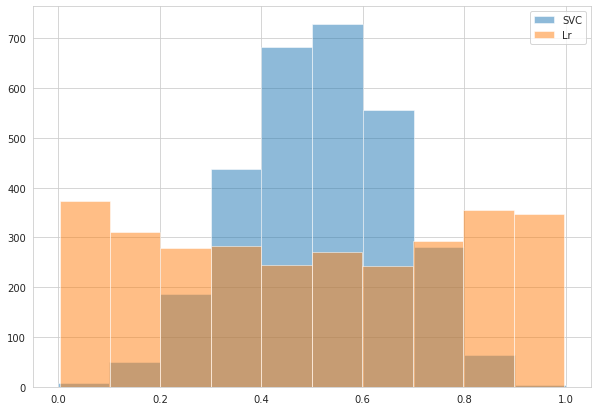

In [17]:
plt.figure(figsize=(10, 7))
plt.hist(svc_pred, alpha=0.5, label='SVC')
plt.hist(lr_pred, alpha=0.5, label='Lr')
plt.legend();

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [41]:
#your code here
svc = LinearSVC(max_iter=100000, C=4)
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8477506666411818


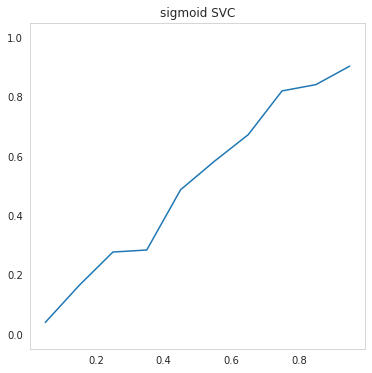

In [42]:
plot_calibration_curve(y_test, sigmoid_svc_pred)
plt.title('sigmoid SVC');

In [41]:
#your code here
svc = LinearSVC(max_iter=100000, C=4)
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8477506666411818


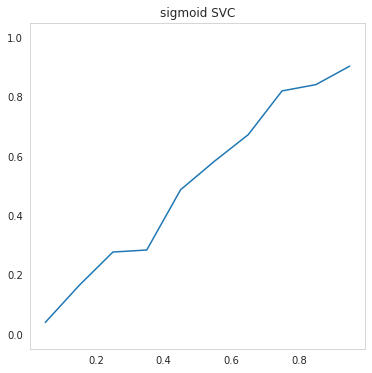

In [42]:
plot_calibration_curve(y_test, sigmoid_svc_pred)
plt.title('sigmoid SVC');

In [43]:
svc = LinearSVC(max_iter=100000, C=4)
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.84757108801975


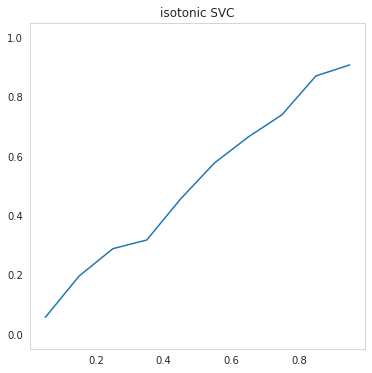

In [44]:
plot_calibration_curve(y_test, isotonic_svc_pred)
plt.title('isotonic SVC');

In [45]:
#your code here
lr = LogisticRegression(max_iter=100000, C=4)
sigmoid_lr = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

SVC ROC-AUC: 0.8479404687979923


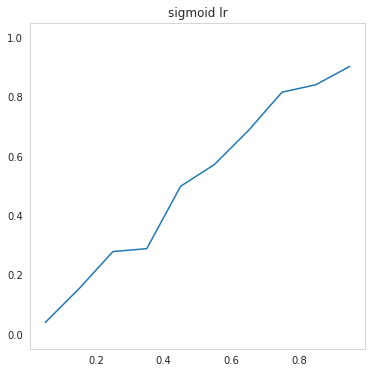

In [46]:
plot_calibration_curve(y_test, sigmoid_lr_pred)
plt.title('sigmoid lr');

In [49]:
#your code here
lr = LogisticRegression(max_iter=100000, C=4)
isotonic_lr = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_lr_pred))

SVC ROC-AUC: 0.8479404687979923


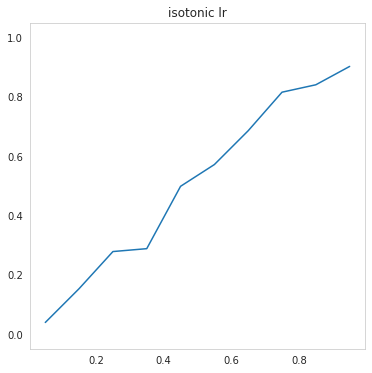

In [50]:
plot_calibration_curve(y_test, isotonic_lr_pred)
plt.title('isotonic lr');

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [165]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [6]:
X = df.drop(columns=['y'])
y = np.where(df.y == "yes", 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=777, stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__:

In [ ]:
X_train

In [9]:
numeric_data = X_train.select_dtypes([np.number])

In [10]:
categor_data = X_train.select_dtypes(["object"])

In [11]:
numeric_features=numeric_data.columns

In [12]:
categorical=categor_data.columns

In [13]:
enc = OrdinalEncoder()

In [ ]:
X_train_enc = enc.fit_transform(X_train[categor_col])

In [152]:
X_test_enc = enc.transform(X_test[categor_col])

In [255]:
column_transformer = ColumnTransformer([
    ('enc', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('enc_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [214]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 18.4 s, sys: 974 ms, total: 19.4 s
Wall time: 39.6 s


In [215]:
y_pred = model.predict(X_test)

In [216]:
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5673
Test AUC-ROC = 0.6948


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [249]:


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
     ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [218]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 55.8 s, sys: 4.21 s, total: 1min
Wall time: 2min 4s


In [219]:
y_pred = model.predict(X_test)

In [220]:
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5737
Test AUC-ROC = 0.7013


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [56]:
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.model_selection import KFold
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None, noise=False, C=0):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
            
        self.noise = noise
        self.C = C
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                   
                if self.noise == True:
                    y_noise = (y+np.random.normal(scale=0.1, size=y.shape))
                    tmap[unique] = (y_noise[X[col]==unique].sum() + self.C*(y_noise.mean())) / (len(y_noise[X[col]==unique]) + self.C)
                else:
                    tmap[unique] = (y[X[col]==unique].sum() + self.C*(y.mean())) / (len(y[X[col]==unique]) + self.C)
                    
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)
    
    
    

class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [16]:
column_transformer = ColumnTransformer([
    ('tge', TargetEncoder(noise=False), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('tge_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [17]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 43 s, sys: 2.56 s, total: 45.5 s
Wall time: 1min 32s


In [18]:
y_pred = model.predict(X_test)

In [22]:
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5676
Test AUC-ROC = 0.6917


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

### С шумом

In [23]:
column_transformer = ColumnTransformer([
    ('tge', TargetEncoder(noise=True), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('tge_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [24]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 42.3 s, sys: 2.6 s, total: 44.9 s
Wall time: 1min 31s


In [25]:
y_pred = model.predict(X_test)

In [26]:
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5670
Test AUC-ROC = 0.6912


### По фолдам

In [27]:
column_transformer = ColumnTransformer([
    ('tge', TargetEncoderCV(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('tge_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [28]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 39.3 s, sys: 2.41 s, total: 41.7 s
Wall time: 1min 25s


In [29]:
y_pred = model.predict(X_test)

In [30]:
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5663
Test AUC-ROC = 0.6908


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [ ]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [61]:
column_transformer = ColumnTransformer([
    ('tge', TargetEncoder(C=1), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('tge_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [62]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 41.9 s, sys: 2.6 s, total: 44.5 s
Wall time: 1min 31s


In [63]:
y_pred = model.predict(X_test)

In [64]:
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5676
Test AUC-ROC = 0.6917


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [79]:
column_transformer = ColumnTransformer([
    ('tge', TargetEncoder(C=1), categorical.union(["age"])),
    ('scaling', StandardScaler(), numeric_features.drop("age"))
])

pipeline = Pipeline(steps=[
    ('tge_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [80]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 3min 30s, sys: 13.6 s, total: 3min 43s
Wall time: 7min 36s


In [81]:
y_pred = model.predict(X_test)

In [82]:
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5676
Test AUC-ROC = 0.6917


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [ ]:
#your code here

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [8]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])

y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [9]:
numeric_data = X_train.select_dtypes([np.number])

In [10]:
categor_data = X_train.select_dtypes(["object"])

In [11]:
numeric_features=numeric_data.columns

In [12]:
categorical=categor_data.columns

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [13]:
pd.DataFrame(OneHotEncoder().fit_transform(X_train[categorical]).toarray()).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [8]:
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
     ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [253]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 4.49 s, total: 1min 7s
Wall time: 2min 20s


In [254]:
y_pred = model.predict(X_test)
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.4967
Test AUC-ROC = 0.6140


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [17]:
X_cat_ohe = pd.DataFrame(OneHotEncoder().fit_transform(X[categorical]).toarray())

In [18]:
X_pr = pd.concat([X.drop(columns=categorical), X_cat_ohe], axis=1)

In [290]:
#your code here
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_pr, y)

LogisticRegression(max_iter=10000)

In [301]:
coef = pd.Series(lr.coef_[0], index = X_pr.columns)

In [303]:
columns = np.abs(coef).sort_values(ascending=False)[:40].index

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X_pr[columns], y, test_size=0.2, random_state=777, stratify=y)

In [306]:
pipeline = Pipeline(steps=[
    ('lr', LogisticRegression(max_iter=10000))
])

In [307]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 1min 18s, sys: 5.08 s, total: 1min 23s
Wall time: 2min 54s


In [308]:
y_pred = model.predict(X_test)
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5033
Test AUC-ROC = 0.6068


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [320]:
columns = ['cons.price.idx', 'previous',   'emp.var.rate', 'euribor3m', 'campaign', 'cons.conf.idx']

In [328]:
column_transformer = ColumnTransformer([
     ('scaling', StandardScaler(), columns)
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [329]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 41.7 s, sys: 2.36 s, total: 44.1 s
Wall time: 1min 32s


In [330]:
y_pred = model.predict(X_test)
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.4970
Test AUC-ROC = 0.6097


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [315]:
column_transformer = ColumnTransformer([
     ('scaling', StandardScaler(), X_train.columns)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [317]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 20 s, sys: 1.13 s, total: 21.2 s
Wall time: 44.1 s


In [318]:
y_pred = model.predict(X_test)
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.4970
Test AUC-ROC = 0.6102


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [345]:
%%time
from scipy.stats import ttest_ind
columns = X_pr.columns
t_list = []
col_name = []
for column in columns:
    t, pv = ttest_ind(X_pr[y == True][column], X_pr[y == False][column])
    t_list.append(t)
    col_name.append(column)
    
t_df = pd.DataFrame({"t" : t_list, "col_name" : col_name})

CPU times: user 558 ms, sys: 0 ns, total: 558 ms
Wall time: 1.08 s


In [377]:
t_df["t_abs"] = np.abs(t_df["t"])

In [378]:
columns = t_df.sort_values("t_abs", ascending = False)[:40]["col_name"].tolist()

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X_pr[columns], y, test_size=0.2, random_state=777, stratify=y)

In [381]:
pipeline = Pipeline(steps=[
    ('lr', LogisticRegression(max_iter=10000))
])

In [382]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 2min 12s, sys: 8.63 s, total: 2min 21s
Wall time: 4min 54s


In [383]:
y_pred = model.predict(X_test)
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.5095
Test AUC-ROC = 0.6172


In [384]:
column_transformer = ColumnTransformer([
     ('scaling', StandardScaler(), X_train.columns)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [385]:
%%time
model = pipeline.fit(X_train, y_train)

CPU times: user 14.8 s, sys: 994 ms, total: 15.7 s
Wall time: 32.5 s


In [386]:
y_pred = model.predict(X_test)
print("Test AUC-PR = %.4f" % auc_pr(y_test, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_test, y_pred))

Test AUC-PR = 0.4987
Test AUC-ROC = 0.6136


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [19]:
#your code here
X_train, X_test, y_train, y_test = train_test_split(X_pr, y, test_size=0.2, random_state=777, stratify=y)

In [20]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, random_state=777, stratify=y_train)

In [21]:
pipeline = Pipeline(steps=[
    ('lr', LogisticRegression(max_iter=10000))
])

In [ ]:
list_auc_pr = []

for column in X_train1.columns:
    columns = X_train1.columns.tolist()
    columns.remove(column)
    model = pipeline.fit(X_train1[columns], y_train1)
    y_pred = model.predict(X_train2[columns])
    list_auc_pr.append(auc_pr(y_train2, y_pred))
    print(column)

age
campaign
pdays
previous
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
list_auc_pr

In [433]:
len(X_train1.columns)

62

In [432]:
len(columns)

61

In [ ]:
model = pipeline.fit(X_train1, y_train1)

In [382]:
%%time
model = pipeline.fit(X_train1, y_train1)

CPU times: user 2min 12s, sys: 8.63 s, total: 2min 21s
Wall time: 4min 54s


In [383]:
y_pred = model.predict(X_train2)

In [ ]:
auc_pr(y_train1, y_pred)

In [383]:
print("Test AUC-PR = %.4f" % auc_pr(y_train1, y_pred))
print("Test AUC-ROC = %.4f" % roc_auc_score(y_train1, y_pred))

Test AUC-PR = 0.5095
Test AUC-ROC = 0.6172


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [142]:
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])

y = (df.y == 'yes')

In [4]:
numeric_data = X.select_dtypes([np.number])

In [5]:
categor_data = X.select_dtypes(["object"])

In [6]:
numeric_features=numeric_data.columns

In [7]:
categorical=categor_data.columns

In [8]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
     ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000))
])

In [99]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, make_scorer
kf = KFold(n_splits=5, shuffle=True, random_state=500)

In [100]:
y_pred = cross_val_predict(pipeline, X, y, cv=kf)

In [101]:
mean = np.mean((y_pred*y*10) - y_pred*1)
std = np.std((y_pred*y*10) - y_pred*1)
print("Profit by user %.3f$" % mean)
print("Std %.3f$" % std)

Profit by user 0.206$
Std 1.385$


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [82]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, make_scorer
kf = KFold(n_splits=5, shuffle=True)

In [83]:
y_pred = cross_val_predict(pipeline, X, y, cv=kf)

In [98]:
mean = np.mean((y_pred*y*np.random.uniform(0,20,len(y_pred))) - y_pred*1)
std = np.std((y_pred*y*np.random.uniform(0,20,len(y_pred))) - y_pred*1)
print("Profit by user %.3f$" % mean)
print("Std %.3f$" % std)

Profit by user 0.210$
Std 1.646$


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [105]:
pd.DataFrame({"mean_profit": [mean], "std_profit": [std]})

,mean_profit,std_profit
0,0.203359,1.656709


In [106]:
#your code here
kf = KFold(n_splits=5, shuffle=True)

profit_by_reg = pd.DataFrame()

for i in np.logspace(-2, 1, 4):

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('lr', LogisticRegression(max_iter=10000, C = i))
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=kf)
    
    mean = np.mean((y_pred*y*np.random.uniform(0,20,len(y_pred))) - y_pred*1)
    
    std = np.std((y_pred*y*np.random.uniform(0,20,len(y_pred))) - y_pred*1)
    
    df = pd.DataFrame({"C": [i], "mean_profit": [mean], "std_profit": [std]})
    
    profit_by_reg = profit_by_reg.append(df)
    
    print(i)

0.01
0.1
1.0
10.0


In [107]:
profit_by_reg

,C,mean_profit,std_profit
0,0.01,0.203021,1.609090
0,0.10,0.215654,1.729376
0,1.00,0.221623,1.688893
0,10.00,0.221291,1.741134


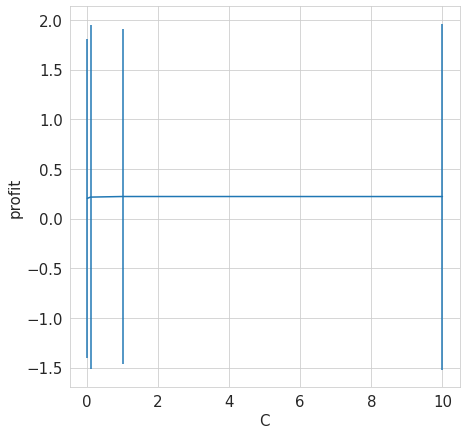

In [113]:
plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(figsize=(7, 7))
axs.errorbar(profit_by_reg["C"], profit_by_reg['mean_profit'], yerr=profit_by_reg['std_profit'])
axs.set_xlabel('C')
axs.set_ylabel('profit');

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [9]:
from sklearn.metrics import recall_score 

In [ ]:
prob_pred = cross_val_predict(pipeline, X, y, cv=kf, method = "predict_proba")

In [ ]:
thresholds = np.arange(0, 0.9, 0.01)

In [140]:
recall_score_list = []
precision_score_list = []

for threshold in thresholds:
    recall_score_list.append(recall_score(y, prob_pred[:,1] >= threshold))
    precision_score_list.append(precision_score(y, prob_pred[:,1] >= threshold))

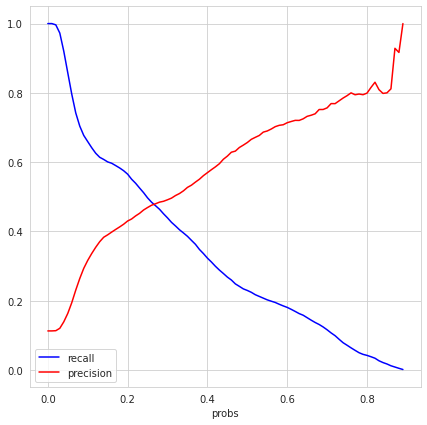

In [145]:
fig, axs = plt.subplots(figsize=(7, 7))
axs.plot(thresholds, recall_score_list, label='recall', color='blue')
axs.plot(thresholds, precision_score_list, label='precision', color='red')
axs.legend()
axs.set_xlabel('probs');

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [114]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
     ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('lr', LogisticRegression(max_iter=10000, C=1))
])

In [115]:
prob_pred = cross_val_predict(pipeline, X, y, cv=kf, method = "predict_proba")

In [116]:
thresholds = np.arange(0, 0.9, 0.01)

In [266]:
profit_df = pd.DataFrame()

In [ ]:
precision_list = []
recall_list = []

for threshold in thresholds:
    
    profit_list = []
    
    y_pred = prob_pred[:,1] >= threshold
    
    profit_dist = (y_pred*y*np.random.uniform(0,20,len(y_pred))) - y_pred*1
    
    mean = np.mean(profit_dist)
    
    std = np.std(profit_dist)
    
    df = pd.DataFrame({"profit_mean":[mean], "profit_std" : [std], "threshold" : threshold, "precision" : precision_score(y, y_pred), "recall" : recall_score(y, y_pred)})
   
    profit_df = profit_df.append(df)

In [37]:
import seaborn as sns

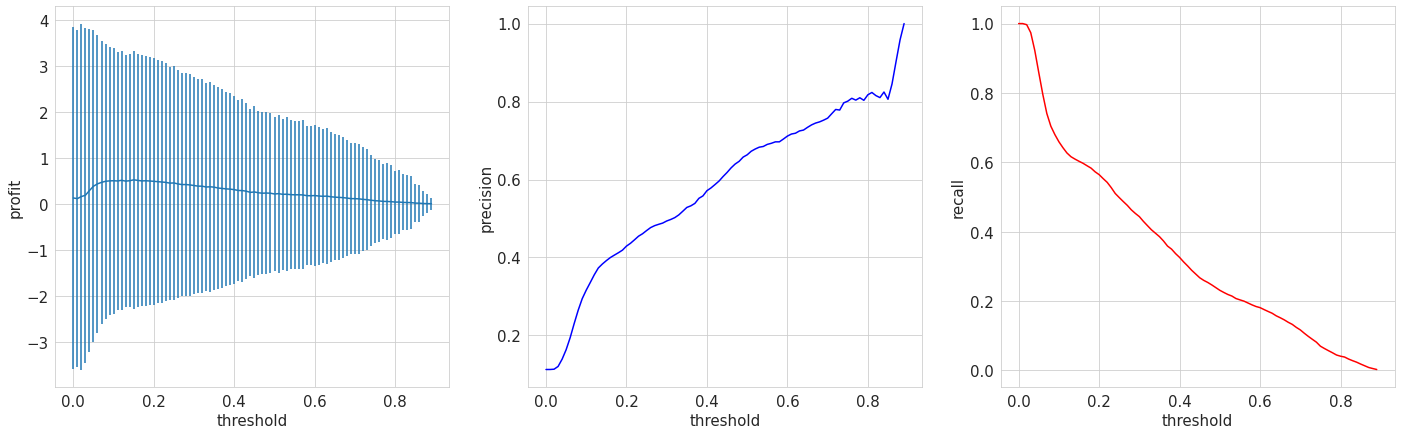

In [268]:
plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(1, 3, figsize=(24, 7))
axs[0].errorbar(profit_df["threshold"], profit_df['profit_mean'], yerr=profit_df['profit_std'])
axs[0].set_xlabel('threshold')
axs[0].set_ylabel('profit')


axs[1].plot(profit_df['threshold'], profit_df['precision'], color='blue')
axs[1].set_xlabel('threshold')
axs[1].set_ylabel('precision')

axs[2].plot(profit_df['threshold'], profit_df['recall'], color='red')
axs[2].set_xlabel('threshold')
axs[2].set_ylabel('recall');

In [272]:
profit_df[profit_df.profit_mean == np.max(profit_df.profit_mean)]

,profit_mean,profit_std,threshold,precision,recall
0,0.521475,2.802043,0.15,0.391956,0.602802


Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#your code here

In [282]:
auc(profit_df["recall"], profit_df["precision"])

0.45037752637954215

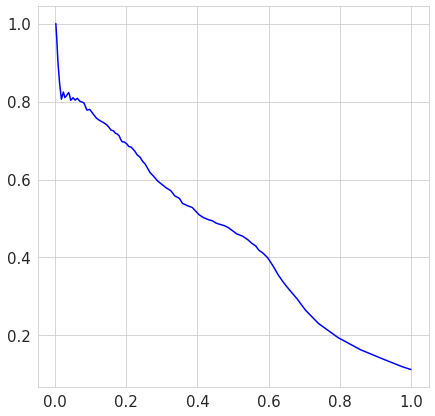

In [281]:
fig, axs = plt.subplots(figsize=(7, 7))

axs.plot(profit_df["recall"], profit_df["precision"], label='PR', color='blue')

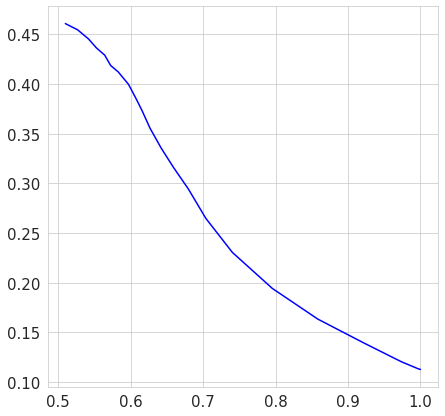

In [278]:
fig, axs = plt.subplots(figsize=(7, 7))

axs.plot(profit_df[profit_df["recall"] >= 0.5]["recall"], profit_df[profit_df["recall"] >= 0.5]["precision"], label='PR', color='blue')

# axs[0].set_title('PR')
# axs[1].set_title('ROC')

# axs[0].set_xlabel('recall')
# axs[0].set_ylabel('precision')

# axs[1].set_xlabel('fpr')
# axs[1].set_ylabel('tpr')

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__